In [1]:
from models import *
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context(context="talk")

import os, re, sys
from keras.layers import CuDNNLSTM,CuDNNGRU

import pandas as pd
import ast, time
import matplotlib.pyplot as plt
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE
import re, io, nltk, torch 
from numpy.linalg import norm
from tqdm import tqdm, trange
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from nltk.corpus import stopwords
from collections import Counter

from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau    
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()


emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " <html> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " <number> ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Using TensorFlow backend.


Se encontraron 1193514 terminos con sus vectores de embedding.


In [2]:
train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/train_format.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/val_format.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Harassment/test_format.csv")

dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

22107

In [3]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

        
glove_matrix = np.zeros((k, g_dim))

for word, i in Word2Index_valid.items():
    vector = embeddings_index.get(word)    
    glove_matrix[i] = vector
    
glove_matrix.shape

(14642, 200)

In [4]:
M_GLOVE_space= glove_matrix

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [5]:
MAX_LEN = 33

print ("Conteo por harassment val\n", Counter(val['Label']))
print ("Conteo por harassment test\n", Counter(test['Label']))

ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

    
ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


Conteo por harassment val
 Counter({'NonH': 1493, 'SexualH': 525, 'IndirectH': 71, 'PhysicalH': 36})
Conteo por harassment test
 Counter({'NonH': 1601, 'SexualH': 340, 'IndirectH': 106, 'PhysicalH': 76})


In [6]:
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], g_dim))
i=0
for in_id in input_ids:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    if n==0:
        x_train[i]=vector
        i+=1
        continue
        
    else:
        for idv in in_id:
            if idv!=0:
                vector+=M_GLOVE_space[idv]
        x_train[i]=(vector/n)
        i+=1   
    
    
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], g_dim))
i=0
for in_id in input_ids_val:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_GLOVE_space[idv]
    x_val[i]=(vector/n)
    i+=1  
    
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], g_dim))
i=0
for in_id in input_ids_test:
    vector=np.zeros(g_dim)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=M_GLOVE_space[idv]
    x_test[i]=(vector/n)
    i+=1  

In [7]:
y_train.shape

(6374, 4)

In [8]:
x_train.shape

(6374, 200)

In [9]:
n_labels.shape

(6374,)

In [10]:

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando SMOTE ", i,"\n")
    
    sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
    x_train_smote, y_train_smote = sm.fit_sample(np.asarray(x_train, dtype='float32'), np.asarray(n_labels, dtype='float32'))
    print (y_train_smote.shape)

    x_new_train=np.expand_dims(x_train_smote, axis=-1)
    x_new_val=np.expand_dims(x_val, axis=-1)
    x_new_test=np.expand_dims(x_test, axis=-1)

    y_train=to_categorical(y_train_smote,num_classes=4)

    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_smote), y_train_smote)
    print ("class_weights Training set", class_weights)

    cnn1=create_ccn1(x_new_train.shape[1:])
    trained, hist =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    
    cnn2=create_cnn2(x_new_train.shape[1:])
    trained, hist =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)

    rnn1=create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)

    rnn2=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)

    rnn3=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
    trained, hist =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


Entrenando SMOTE  1 

(14644,)
class_weights Training set [1. 1. 1. 1.]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Train cnn1 : 0.9108850040972412
F1-score None sobre Train cnn1 : [0.85386819 0.97612661 0.96023176 0.84706531]
F1-score macro sobre Train cnn1 : 0.9093229683622364

Accuracy sobre Val cnn1 : 0.8145882352941176
F1-score None sobre Val cnn1 : [0.89600551 0.1037037  0.06315789 0.75268817]
F1-score macro sobre Val cnn1 : 0.45388882003135744

Accuracy sobre Test cnn1 : 0.7819123881300047
F1-score None sobre Test cnn1 : [0.87784546 0.15238095 0.20689655 0.67357513]
F1-score macro sobre Test cnn1 : 0.47767452423207124

Accuracy sobre Train cnn2 : 0.8960666484567058
F1-score None sobre Train cnn2 : [0.85074419 0.96237832 0.94277069 0.8187355 ]
F1-score macro sobre Train cnn2 : 0.893657175229488


Accuracy sobre Test rnn3 : 0.4780970325011776
F1-score None sobre Test rnn3 : [0.63801262 0.13355049 0.09418283 0.40272109]
F1-score macro sobre Test rnn3 : 0.3171167552040043

Entrenando SMOTE  3 

(14644,)
class_weights Training set [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9099289811526905
F1-score None sobre Train cnn1 : [0.86465355 0.97900969 0.96066946 0.83544304]
F1-score macro sobre Train cnn1 : 0.9099439318270118

Accuracy sobre Val cnn1 : 0.835764705882353
F1-score None sobre Val cnn1 : [0.90201254 0.09174312 0.10344828 0.76235741]
F1-score macro sobre Val cnn1 : 0.46489033667331414

Accuracy sobre Test cnn1 : 0.8040508714083844
F1-score None sobre Test cnn1 : [0.88962806 0.11392405 0.04494382 0.65028902]
F1-score macro sobre Test cnn1 : 0.4246962374715002

Accuracy sobre Train cnn2 : 0.9013930620049166
F1-score None sobre Train cnn2 : [0.84857225 0.97054922 0.94980695 0.83039014]
F1-score macro sobre Train cnn2 : 0.8998296408777868

Accuracy sobre Val cnn2 : 0.7717647058


Accuracy sobre Test rnn3 : 0.6373056994818653
F1-score None sobre Test rnn3 : [0.77770316 0.1377551  0.13483146 0.4469914 ]
F1-score macro sobre Test rnn3 : 0.3743202808018236


In [11]:
#NIPS
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("SMOTE F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("SMOTE F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("SMOTE Accuracy promedio para",key,":" ,temp/5)

SMOTE F1-score promedio para cnn1 : [0.86917674 0.13701513 0.14933818 0.63945064]
SMOTE F1-score promedio para cnn2 : [0.85271417 0.15414488 0.1803698  0.63171435]
SMOTE F1-score promedio para rnn1 : [0.70923388 0.14715806 0.14939561 0.42892343]
SMOTE F1-score promedio para rnn2 : [0.80887738 0.12282483 0.11977624 0.4720153 ]
SMOTE F1-score promedio para rnn3 : [0.73496168 0.13157874 0.11951948 0.4212189 ]

SMOTE F1-score macro promedio para cnn1 : 0.4487451734977346 desvest:  0.01925442996324263
SMOTE F1-score macro promedio para cnn2 : 0.4547357992646256 desvest:  0.009077371592371162
SMOTE F1-score macro promedio para rnn1 : 0.3586777438194172 desvest:  0.01586341080972947
SMOTE F1-score macro promedio para rnn2 : 0.3808734361596903 desvest:  0.013517951236456358
SMOTE F1-score macro promedio para rnn3 : 0.3518197014206027 desvest:  0.02143305764574409

SMOTE Accuracy promedio para cnn1 : 0.770325011775789
SMOTE Accuracy promedio para cnn2 : 0.7453603391427225
SMOTE Accuracy promedi

In [14]:
cnn1=create_ccn1(x_new_train.shape[1:])
trained, hist =train_model(cnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/harassment_baselines/SMOTE/cnn1.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn1')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

cnn2=create_cnn2(x_new_train.shape[1:])
trained, hist =train_model(cnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/harassment_baselines/SMOTE/cnn2.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'cnn2')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn1=create_complex_GRU_2(128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn1, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/harassment_baselines/SMOTE/rnn1.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn1')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn2=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn2, x_new_train, y_train, x_new_val, y_val, class_weights, e=7, BS=32, verb=0, focal=False)
trained.save('../new_glove_augmented/harassment_baselines/SMOTE/rnn2.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn2')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)

rnn3=create_complex_GRU_3(256,128,64,"adam",x_new_train.shape[1:])
trained, hist =train_model(rnn3, x_new_train, y_train, x_new_val, y_val, class_weights, e=4, BS=32, verb=0, focal=True)
trained.save('../new_glove_augmented/harassment_baselines/SMOTE/rnn3.h5')
f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_new_train, x_new_val, x_new_test, y_train_smote, etiq_v, etiq_t, 'rnn3')
print ("Acc:", acc_t, "F-ma", f1_ma_t, "None:", f1_t)


Accuracy sobre Train cnn1 : 0.9123190385140671
F1-score None sobre Train cnn1 : [0.86684857 0.97946584 0.96061026 0.84171577]
F1-score macro sobre Train cnn1 : 0.9121601120425276

Accuracy sobre Val cnn1 : 0.8315294117647059
F1-score None sobre Val cnn1 : [0.89993329 0.09917355 0.06779661 0.76492537]
F1-score macro sobre Val cnn1 : 0.45795720647051685

Accuracy sobre Test cnn1 : 0.7936881771078662
F1-score None sobre Test cnn1 : [0.88455587 0.14358974 0.0990099  0.65924896]
F1-score macro sobre Test cnn1 : 0.4466011166304156
Acc: 0.7936881771078662 F-ma 0.4466011166304156 None: [0.88455587 0.14358974 0.0990099  0.65924896]

Accuracy sobre Train cnn2 : 0.8996858781753619
F1-score None sobre Train cnn2 : [0.85389474 0.96865037 0.94374407 0.82832736]
F1-score macro sobre Train cnn2 : 0.8986541352754112

Accuracy sobre Val cnn2 : 0.8329411764705882
F1-score None sobre Val cnn2 : [0.90792146 0.10294118 0.07058824 0.77953488]
F1-score macro sobre Val cnn2 : 0.4652464394773671

Accuracy sobr

## comité

In [15]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas


In [16]:
cnn1= load_model('../new_glove_augmented/harassment_baselines/SMOTE/cnn1.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})  
cnn2= load_model('../new_glove_augmented/harassment_baselines/SMOTE/cnn2.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn1= load_model('../new_glove_augmented/harassment_baselines/SMOTE/rnn1.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 
rnn2= load_model('../new_glove_augmented/harassment_baselines/SMOTE/rnn2.h5') 
rnn3= load_model('../new_glove_augmented/harassment_baselines/SMOTE/rnn3.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()}) 

list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
index_models=np.arange(5)
dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
ind=np.arange(5)
dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))
bs=32

print ("Agregando predicciones Test set")    
predicciones_all_test=[]

for i in dict_trainedModel.keys(): 
    a_evaluar=dict_models[i]
    predicciones_all_test.append(dict_trainedModel[i].predict(x_new_test, batch_size=bs))
predichos_all_test=np.concatenate(np.asarray(predicciones_all_test),axis=-1)


Agregando predicciones Test set


In [17]:
print ("--------TESTING SET--------")

print ("\nCommittee Best Fit")
trainPredicho, maxPredicho, confianzas = predecir_modelos(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score SDQC:",f1_no)


print ("\nCommittee Norm")
trainPredicho, maxPredicho, confianzas = predecir_modelos_norm(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None) 
print("F1-score SDQC:",f1_no)


print ("\nCommittee Voting")
trainPredicho, maxPredicho, confianzas = predecir_modelos_average(bs,predichos_all_test)
acc_comite= accuracy_score(etiq_t, trainPredicho)  
print("Accuracy:",acc_comite)
f1=f1_score(etiq_t, trainPredicho, average='macro') 
print("F1-macro:",f1)
f1_no=f1_score(etiq_t, trainPredicho, average=None)  
print("F1-score SDQC:",f1_no)

--------TESTING SET--------

Committee Best Fit
Accuracy: 0.7527084314649082
F1-macro: 0.4382845504450935
F1-score SDQC: [0.85696633 0.13852814 0.18978102 0.56786271]

Committee Norm
Accuracy: 0.7691945360339143
F1-macro: 0.42695909236664176
F1-score SDQC: [0.86670762 0.10928962 0.14814815 0.58369099]

Committee Voting
Accuracy: 0.7710786622703721
F1-macro: 0.4342649904521645
F1-score SDQC: [0.86846958 0.11398964 0.16071429 0.59388646]


In [20]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1
    
ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

Pesos de clases: [1. 1. 1. 1.]


(2123, 33, 200)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(train.Tweet).toarray()
labels = [d_lab[y] for y in train.Label]
features.shape

(6374, 5469)

In [22]:
x_val = tfidf.transform(val.Tweet).toarray()
y_val = [d_lab[y] for y in val['Label'].values]
print (x_val.shape)

x_test = tfidf.transform(test.Tweet).toarray()
y_test = [d_lab[y] for y in test['Label'].values]
print (x_test.shape)

(2125, 5469)
(2123, 5469)



ENTRENANDO MODELO Random Forest
Accuracy VAL: 0.7096470588235294
F1-score VAL: 0.22192482408023192
F1-score none average VAL: [0.82865871 0.         0.         0.05904059]


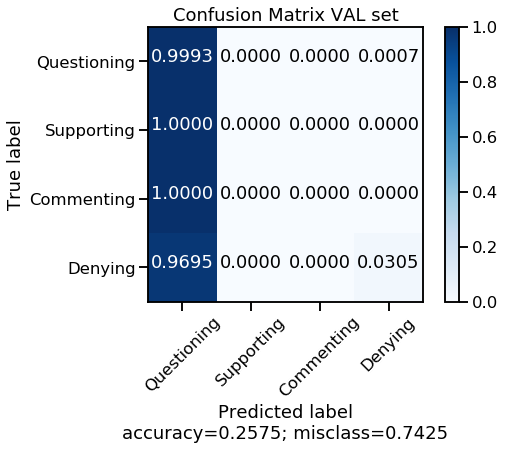

Accuracy TEST: 0.7541215261422516
F1-score TEST: 0.21495703544575726
F1-score none average TEST: [0.85982814 0.         0.         0.        ]


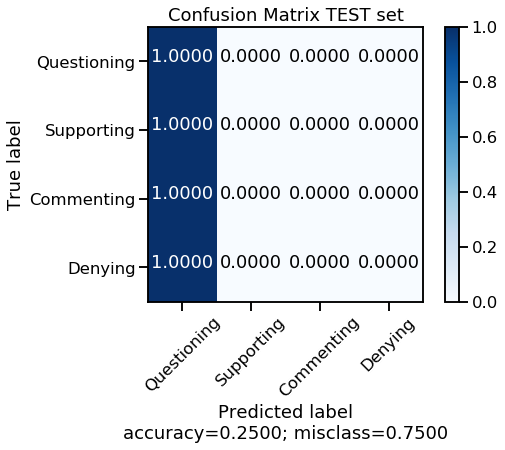


ENTRENANDO MODELO Linear SVM
Accuracy VAL: 0.8489411764705882
F1-score VAL: 0.45064525316243054
F1-score none average VAL: [0.90921228 0.06122449 0.04081633 0.79132791]


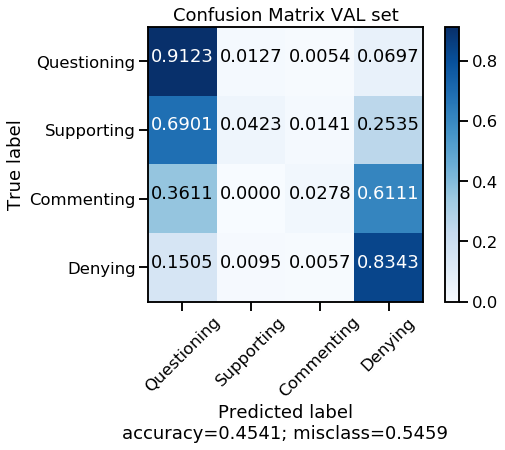

Accuracy TEST: 0.80357983984927
F1-score TEST: 0.4385948123376284
F1-score none average TEST: [0.88581102 0.07042254 0.12       0.6781457 ]


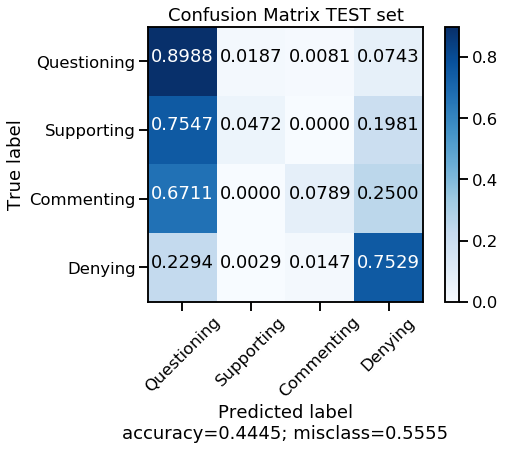


ENTRENANDO MODELO SVM


In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(class_weight='balanced'),
    SVC(class_weight='balanced'),
]

modelos={0:'Random Forest', 1: 'Linear SVM', 2:'SVM'}
i=0

for model_to_train in models:
    print ("")
    print ("ENTRENANDO MODELO", modelos[i])
    model=model_to_train
    model.fit(features, labels)
    y_pred_val = model.predict(x_val)
    y_pred_test = model.predict(x_test)
    
    acc= accuracy_score(y_val, y_pred_val)  
    f1_ma=f1_score(y_val, y_pred_val, average='macro')
    f1_no=f1_score(y_val, y_pred_val, average=None)

    print ("Accuracy VAL:",acc)  
    print ("F1-score VAL:",f1_ma)
    print ("F1-score none average VAL:",f1_no)

    matriz=confusion_matrix(y_val, y_pred_val)
    plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix VAL set")
    
    acc= accuracy_score(y_test, y_pred_test)  
    f1_ma=f1_score(y_test, y_pred_test, average='macro')
    f1_no=f1_score(y_test, y_pred_test, average=None)

    print ("Accuracy TEST:",acc)  
    print ("F1-score TEST:",f1_ma)
    print ("F1-score none average TEST:",f1_no)

    matriz=confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["Questioning","Supporting","Commenting","Denying"],"Confusion Matrix TEST set")
    i+=1

    


# Harassment

/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


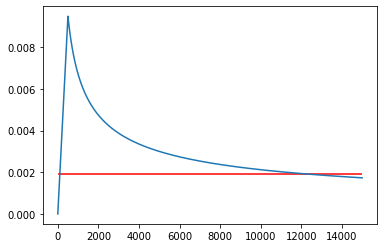

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 

factor=3
warmup=500

x=np.arange(15000)
y=[factor * 200 ** (-0.5) * min(xi ** (-0.5), xi * warmup ** (-1.5)) for xi in x]
plt.hlines(0.0019, 0, 15000, 'r')
plt.plot(x, y)
plt.show()